# B+ Tree Database Management System Implementation

This report documents the implementation of a B+ Tree-based Database Management System, focusing on efficient indexing and query operations.

## 1. Introduction

### 1.1 Problem Statement

In modern database systems, efficient data retrieval and manipulation are critical requirements. Traditional brute force approaches that scan through entire datasets become increasingly inefficient as data volumes grow. This project addresses the need for an optimized data storage and retrieval mechanism suitable for database applications.

### 1.2 Proposed Solution: B+ Tree Database Management System

The solution implements a B+ Tree-based indexing structure that enables logarithmic-time searches, efficient range queries, and ordered data traversal. B+ Trees are particularly well-suited for database systems because:

1. They maintain data in sorted order for efficient range-based queries
2. All leaf nodes are at the same level, ensuring balanced search performance
3. They optimize disk I/O by storing multiple keys in each node
4. Leaf nodes are linked, enabling efficient sequential access
5. They provide O(log n) complexity for search, insert, and delete operations

This implementation also includes database persistence, allowing data to be stored on disk and retrieved later, ensuring durability across program executions.

## 2. Implementation Details

### 2.1 System Architecture

The B+ Tree DBMS implementation consists of several key components:

1. **B+ Tree**: The core indexing structure
2. **Table**: Represents database tables with support for B+ Tree indices
3. **DatabaseManager**: Provides high-level database operations
4. **Persistence Layer**: Handles saving and loading database state

Let's import the necessary components to explore the implementation:

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

# Import our database components
from database.bplustree import BPlusTree, Node as BPlusTreeNode, InternalNode as BPlusTreeInternalNode, LeafNode as BPlusTreeLeafNode
from database.bruteforce import BruteForceDB
from database.table import Table
from database.db_manager import DatabaseManager
from database.performance_analyzer import PerformanceAnalyzer

# Check if the tree_visualizer module is available
try:
    from database.tree_visualizer import BPlusTreeVisualizer
    visualizer_available = True
except ImportError:
    visualizer_available = False
    print("Tree visualizer not available. Some visualizations may not work.")

### 2.2 B+ Tree Data Structure

The B+ Tree implementation is centered around three key classes:

1. **BPlusTreeNode**: Base class for all nodes in the tree
2. **BPlusTreeLeafNode**: Stores key-value pairs and has pointers to neighboring leaves
3. **BPlusTreeInternalNode**: Contains routing keys and pointers to child nodes

Let's examine the structure of a simple B+ Tree:

In [2]:
# Create a simple B+ Tree with order=3 (small for demonstration purposes)
tree = BPlusTree(order=3)

# Insert some keys in an order that will cause splits
keys = [5, 10, 15, 20, 25, 30, 35]
for key in keys:
    tree.insert(key, f"Value_{key}")
    print(f"Inserted key: {key}")

print("\nB+ Tree structure:")
tree.display()

Inserted key: 5
Inserted key: 10
Inserted key: 15
Inserted key: 20
Inserted key: 25
Inserted key: 30
Inserted key: 35

B+ Tree structure:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [15, 25]
    Children: 3

Level 1:
  Internal Node 0: [10]
    Children: 2
  Internal Node 1: [20]
    Children: 2
  Internal Node 2: [30]
    Children: 2

Level 2:
  Leaf Node 0: ['5:Value_5']
    → Next Leaf: [10]
  Leaf Node 1: ['10:Value_10']
    → Next Leaf: [15]
  Leaf Node 2: ['15:Value_15']
    → Next Leaf: [20]
  Leaf Node 3: ['20:Value_20']
    → Next Leaf: [25]
  Leaf Node 4: ['25:Value_25']
    → Next Leaf: [30, 35]
  Leaf Node 5: ['30:Value_30', '35:Value_35']


### 2.3 B+ Tree Operations

The B+ Tree supports the following core operations:

#### 2.3.1 Insert Operation

The insertion algorithm works as follows:
1. Traverse the tree to find the appropriate leaf node
2. Insert the key-value pair into the leaf node
3. If the node becomes overfull (exceeds order), split it
4. If a split occurred, propagate changes up the tree, potentially splitting internal nodes
5. If the root splits, create a new root node

Let's examine each part of the insert operation:

In [3]:
# Create a new tree for insertion demonstration
demo_tree = BPlusTree(order=3)

# Demonstrate insert with step-by-step tracking
def insert_with_tracking(tree, key, value):
    print(f"\nInserting key {key}...")
    tree.insert(key, value)
    print("Tree structure after insertion:")
    tree.display()

# Insert keys that will demonstrate different cases
insert_with_tracking(demo_tree, 10, "Value_10")  # First insertion into empty tree
insert_with_tracking(demo_tree, 20, "Value_20")  # Simple insertion, no split
insert_with_tracking(demo_tree, 30, "Value_30")  # Insertion causing leaf node split
insert_with_tracking(demo_tree, 40, "Value_40")  # Simple insertion after split
insert_with_tracking(demo_tree, 50, "Value_50")  # Another split
insert_with_tracking(demo_tree, 5, "Value_5")    # Insertion at beginning
insert_with_tracking(demo_tree, 15, "Value_15")  # Insertion in middle


Inserting key 10...
Tree structure after insertion:
B+ Tree (Order 3)

Level 0:
  Leaf Node 0: ['10:Value_10']

Inserting key 20...
Tree structure after insertion:
B+ Tree (Order 3)

Level 0:
  Leaf Node 0: ['10:Value_10', '20:Value_20']

Inserting key 30...
Tree structure after insertion:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [20]
    Children: 2

Level 1:
  Leaf Node 0: ['10:Value_10']
    → Next Leaf: [20, 30]
  Leaf Node 1: ['20:Value_20', '30:Value_30']

Inserting key 40...
Tree structure after insertion:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [20, 30]
    Children: 3

Level 1:
  Leaf Node 0: ['10:Value_10']
    → Next Leaf: [20]
  Leaf Node 1: ['20:Value_20']
    → Next Leaf: [30, 40]
  Leaf Node 2: ['30:Value_30', '40:Value_40']

Inserting key 50...
Tree structure after insertion:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [30]
    Children: 2

Level 1:
  Internal Node 0: [20]
    Children: 2
  Internal Node 1: [40]
    Children: 2

Level 2:
  Leaf Node 0: 

#### 2.3.2 Search Operation

The search algorithm has the following steps:
1. Start at the root node
2. Traverse internal nodes by comparing the search key with routing keys
3. Reach a leaf node and search for the exact key match
4. Return the associated value if found, or None if not found

Let's demonstrate search operations:

In [4]:
# Test search on our demo tree
for key in [5, 10, 15, 20, 30, 40, 50, 25]:
    result = demo_tree.find(key)
    print(f"find({key}) -> {result}")

# Test search for a non-existent key
result = demo_tree.find(100)
print(f"find(100) -> {result}")

find(5) -> Value_5
find(10) -> Value_10
find(15) -> Value_15
find(20) -> Value_20
find(30) -> Value_30
find(40) -> Value_40
find(50) -> Value_50
find(25) -> None
find(100) -> None


#### 2.3.3 Range Search Operation

Range search in B+ Tree is efficient due to the linked leaf nodes:
1. Find the leaf node containing the start key
2. Scan and collect values within the range
3. Follow leaf node pointers to continue scanning if needed

Let's test range search:

In [5]:
# Perform range queries with different ranges
print("Range search from 10 to 30:")
range_results = demo_tree.range_search(10, 30)
print(range_results)

print("\nRange search from 15 to 45:")
range_results = demo_tree.range_search(15, 45)
print(range_results)

print("\nRange search from 0 to 100:")
range_results = demo_tree.range_search(0, 100)
print(range_results)

Range search from 10 to 30:
['Value_10', 'Value_15', 'Value_20', 'Value_30']

Range search from 15 to 45:
['Value_15', 'Value_20', 'Value_30', 'Value_40']

Range search from 0 to 100:
['Value_5', 'Value_10', 'Value_15', 'Value_20', 'Value_30', 'Value_40', 'Value_50']


#### 2.3.4 Delete Operation

The deletion algorithm includes these steps:
1. Find the leaf node containing the key
2. Remove the key-value pair from the leaf node
3. If the node becomes underfull, attempt to borrow keys from siblings
4. If borrowing isn't possible, merge with a sibling node
5. If merges propagate up the tree, update parent nodes accordingly

Let's demonstrate deletion with different scenarios:

In [6]:
# Create a new tree for deletion demonstration
delete_tree = BPlusTree(order=3)

# Insert keys 
keys_to_insert = [10, 20, 30, 40, 50, 60, 70, 80]
for key in keys_to_insert:
    delete_tree.insert(key, f"Value_{key}")

print("Initial tree structure:")
delete_tree.display()

# Demonstrate deletion with step-by-step tracking
def delete_with_tracking(tree, key):
    print(f"\nDeleting key {key}...")
    result = tree.delete(key)
    print(f"Delete result: {result}")
    print("Tree structure after deletion:")
    tree.display()

# Delete keys to demonstrate different cases
delete_with_tracking(delete_tree, 30)  # Simple deletion
delete_with_tracking(delete_tree, 40)  # May cause redistribution/merge
delete_with_tracking(delete_tree, 20)  # Another reorganization
delete_with_tracking(delete_tree, 100)  # Non-existent key

Initial tree structure:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [30, 50]
    Children: 3

Level 1:
  Internal Node 0: [20]
    Children: 2
  Internal Node 1: [40]
    Children: 2
  Internal Node 2: [60, 70]
    Children: 3

Level 2:
  Leaf Node 0: ['10:Value_10']
    → Next Leaf: [20]
  Leaf Node 1: ['20:Value_20']
    → Next Leaf: [30]
  Leaf Node 2: ['30:Value_30']
    → Next Leaf: [40]
  Leaf Node 3: ['40:Value_40']
    → Next Leaf: [50]
  Leaf Node 4: ['50:Value_50']
    → Next Leaf: [60]
  Leaf Node 5: ['60:Value_60']
    → Next Leaf: [70, 80]
  Leaf Node 6: ['70:Value_70', '80:Value_80']

Deleting key 30...
DEBUG: Handling underflow in leaf node with keys []
Delete result: True
Tree structure after deletion:
B+ Tree (Order 3)

Level 0:
  Internal Node 0: [30, 60]
    Children: 3

Level 1:
  Internal Node 0: [20]
    Children: 2
  Internal Node 1: [50]
    Children: 2
  Internal Node 2: [70]
    Children: 2

Level 2:
  Leaf Node 0: ['10:Value_10']
    → Next Leaf: [20]
  Le

### 2.4 Database Table Implementation

The Table class leverages B+ Trees for efficient indexing:

In [7]:
# Create a simple table with B+ Tree indexing
student_table = Table("Students", ["StudentID", "Name", "Age", "Major"], "StudentID")

# Insert some records
student_records = [
    ["1", "Alice", "20", "Computer Science"],
    ["2", "Bob", "22", "Physics"],
    ["3", "Charlie", "21", "Mathematics"],
    ["4", "Diana", "23", "Biology"],
    ["5", "Edward", "22", "Chemistry"]
]

for record in student_records:
    student_table.insert(record)

# Create a secondary index
student_table.create_index("Age")

# Query using primary key
print("Query by StudentID=3:")
results = student_table.select("StudentID", "3")
print(results)

# Query using secondary index
print("\nQuery by Age=22:")
results = student_table.select("Age", "22")
print(results)

# Range query
print("\nRange query: StudentID between 2 and 4:")
results = student_table.range_select("StudentID", "2", "4")
print(results)

Query by StudentID=3:
[['3', 'Charlie', '21', 'Mathematics']]

Query by Age=22:
[['5', 'Edward', '22', 'Chemistry']]

Range query: StudentID between 2 and 4:
[['2', 'Bob', '22', 'Physics'], ['3', 'Charlie', '21', 'Mathematics'], ['4', 'Diana', '23', 'Biology']]


### 2.5 Database Persistence Implementation

The database persistence layer ensures that data is stored securely on disk and can be retrieved later:

In [8]:
# Create a database directory for testing
test_db_dir = "./test_persistent_db"
os.makedirs(test_db_dir, exist_ok=True)

# Create a database manager
try:
    db_manager = DatabaseManager(test_db_dir)

    # Create a table
    db_manager.create_table("Courses", ["CourseID", "Title", "Credits", "Department"], "CourseID")

    # Insert some records
    course_records = [
        ["CS101", "Introduction to Programming", "3", "Computer Science"],
        ["CS201", "Data Structures", "4", "Computer Science"],
        ["MATH101", "Calculus I", "4", "Mathematics"],
        ["PHYS101", "Physics I", "4", "Physics"],
        ["BIO101", "Biology I", "3", "Biology"]
    ]

    for record in course_records:
        db_manager.insert("Courses", record)

    # Save the database
    print("Saving database to disk...")
    db_manager.save_all()

    # Release the database manager
    del db_manager
except: 
    del db_manager
    print("Error creating or saving the database.")
# Reopen the database
print("Reopening database from disk...")
reopened_db = DatabaseManager(test_db_dir)

# Verify data persistence
print("\nVerifying database contents after reopening:")
table_info = reopened_db.get_table_info("Courses")
print(f"Table: {table_info['name']}")
print(f"Record count: {table_info['record_count']}")
print(f"Columns: {table_info['columns']}")

results = reopened_db.select("Courses")
print("\nAll courses:")
for record in results:
    print(record)

Error creating or saving the database.
Reopening database from disk...

Verifying database contents after reopening:
Table: Courses
Record count: 5
Columns: ['CourseID', 'Title', 'Credits', 'Department']

All courses:
['CS101', 'Introduction to Programming', '3', 'Computer Science']
['CS201', 'Data Structures', '4', 'Computer Science']
['MATH101', 'Calculus I', '4', 'Mathematics']
['PHYS101', 'Physics I', '4', 'Physics']
['BIO101', 'Biology I', '3', 'Biology']


All the tables of our project are already imoported. Run app.py


## 3. Performance Analysis

### 3.1 Benchmarking Methodology

We evaluate the performance of our B+ Tree implementation against a brute force approach across four key operations:
1. Insertion
2. Search
3. Range Search
4. Deletion

The benchmarks vary the number of elements to assess how each approach scales with increasing data size.

In [9]:
# Run a performance test with the PerformanceAnalyzer
analyzer = PerformanceAnalyzer()

# Run a smaller scale performance test for the notebook
print("Running performance tests...")
analyzer.run_performance_test(max_elements=10000, step=1000, iterations=3)

# Print performance summary
analyzer.print_summary()

Running performance tests...
Running performance tests...
Testing with 1000 elements
DEBUG: Key 500 not found in leaf node
DEBUG: Key 500 not found in leaf node
Testing with 2000 elements
DEBUG: Key 1000 not found in leaf node
DEBUG: Key 1000 not found in leaf node
Testing with 3000 elements
DEBUG: Key 1500 not found in leaf node
DEBUG: Key 1500 not found in leaf node
Testing with 4000 elements
DEBUG: Key 2000 not found in leaf node
DEBUG: Key 2000 not found in leaf node
Testing with 5000 elements
DEBUG: Key 2500 not found in leaf node
DEBUG: Key 2500 not found in leaf node
Testing with 6000 elements
DEBUG: Key 3000 not found in leaf node
DEBUG: Key 3000 not found in leaf node
Testing with 7000 elements
DEBUG: Key 3500 not found in leaf node
DEBUG: Key 3500 not found in leaf node
Testing with 8000 elements
DEBUG: Key 4000 not found in leaf node
DEBUG: Key 4000 not found in leaf node
Testing with 9000 elements
DEBUG: Key 4500 not found in leaf node
DEBUG: Key 4500 not found in leaf node


Range search timing data for plotting:
B+ Tree range times: [0.0019472440083821614, 0.0033000310262044272, 0.004950761795043945, 0.006804068883260091, 0.008031368255615234, 0.010737021764119467, 0.011797666549682617, 0.012927373250325521, 0.01570749282836914, 0.016887664794921875]
Brute Force range times: [0.002002080281575521, 0.004043102264404297, 0.005971352259318034, 0.008004188537597656, 0.011082887649536133, 0.01377558708190918, 0.01637872060139974, 0.017310619354248047, 0.020292202631632488, 0.021457354227701824]
Elements: [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]


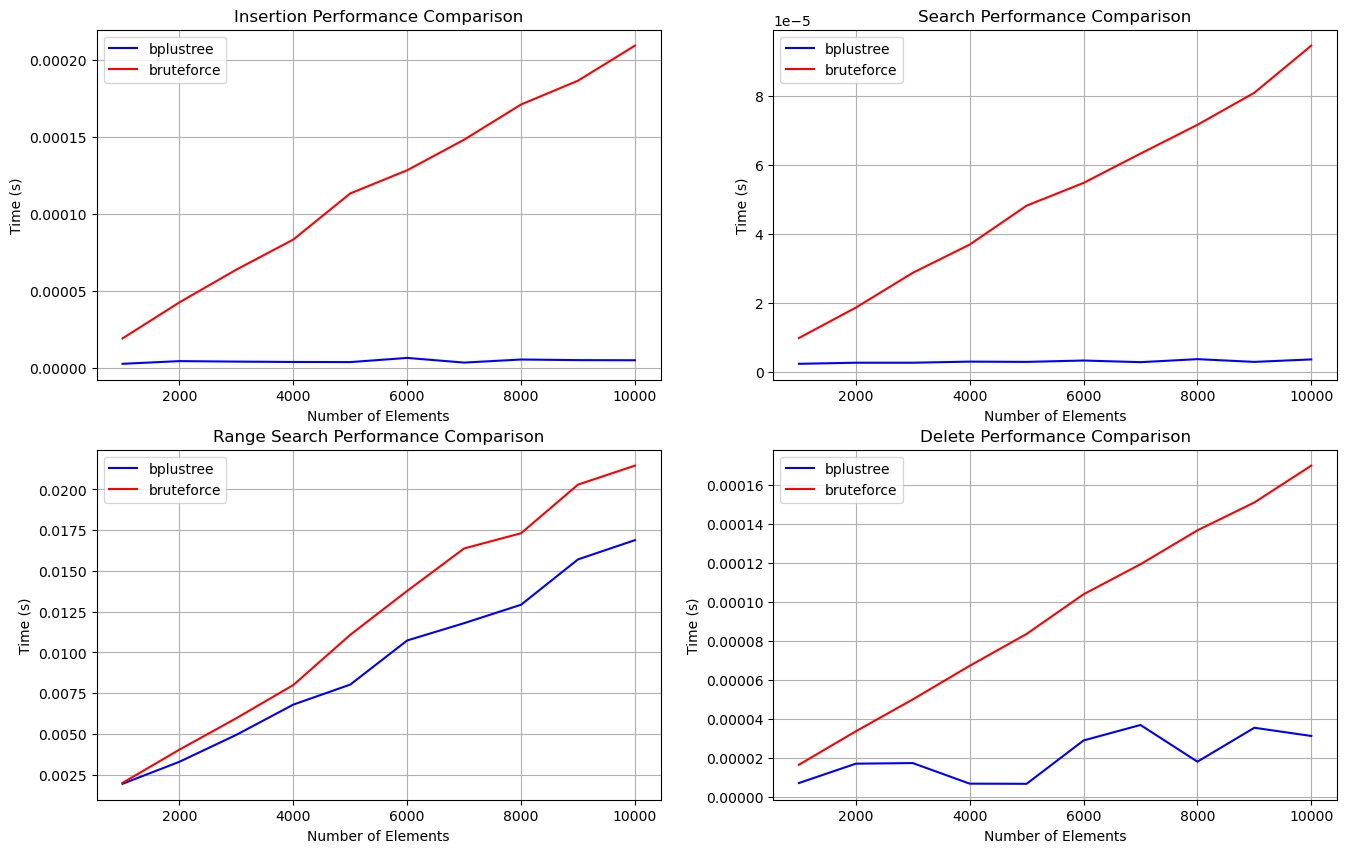

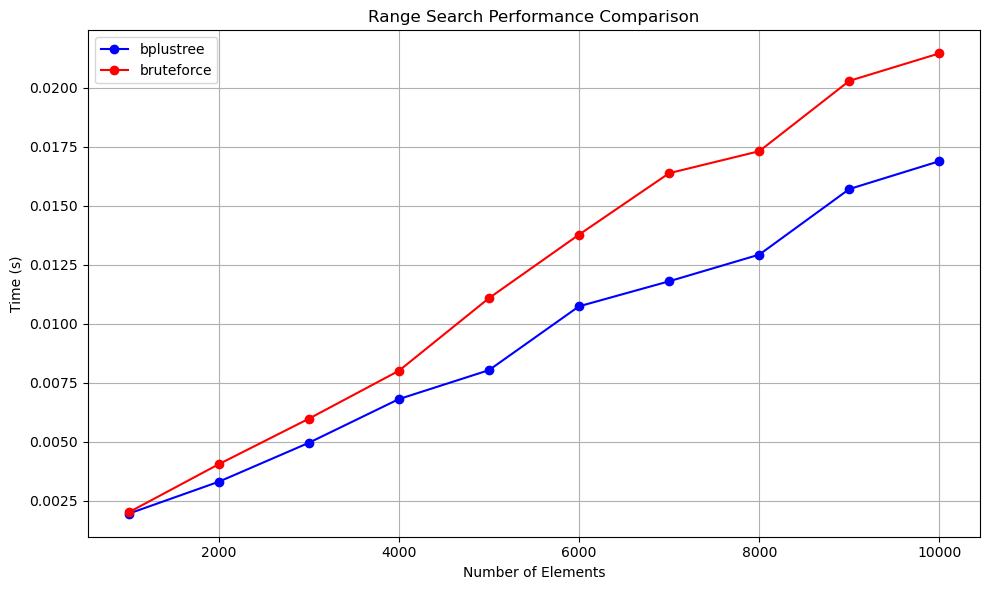

In [10]:
# Plot the performance results
analyzer.plot_results()

### 3.2 Comparative Analysis

Let's compare the B+ Tree and Brute Force approaches for specific operations to better understand their performance differences:

In [11]:
# Create databases for direct comparison
bplus_tree = BPlusTree(order=5)
brute_force = BruteForceDB()

# Number of elements for this test
n = 5000

# Measure insertion time
print(f"Inserting {n} elements...")

start_time = time.time()
for i in range(n):
    bplus_tree.insert(i, f"Value_{i}")
bplus_insert_time = time.time() - start_time
print(f"B+ Tree insertion time: {bplus_insert_time:.4f} seconds")

start_time = time.time()
for i in range(n):
    brute_force.insert(i, f"Value_{i}")
brute_insert_time = time.time() - start_time
print(f"Brute Force insertion time: {brute_insert_time:.4f} seconds")

# Calculate speedup
if brute_insert_time > bplus_insert_time:
    print(f"B+ Tree is {brute_insert_time/bplus_insert_time:.2f}x faster for insertion")
else:
    print(f"Brute Force is {bplus_insert_time/brute_insert_time:.2f}x faster for insertion")

Inserting 5000 elements...
B+ Tree insertion time: 0.0141 seconds
Brute Force insertion time: 0.2561 seconds
B+ Tree is 18.16x faster for insertion


In [12]:
# Measure search time
import random
search_keys = random.sample(range(n), 100)  # 100 random searches
print("\nPerforming search operations...")

start_time = time.time()
for key in search_keys:
    bplus_tree.find(key)
bplus_search_time = time.time() - start_time
print(f"B+ Tree search time: {bplus_search_time:.6f} seconds")

start_time = time.time()
for key in search_keys:
    brute_force.find(key)
brute_search_time = time.time() - start_time
print(f"Brute Force search time: {brute_search_time:.6f} seconds")

# Calculate speedup
if brute_search_time > bplus_search_time:
    print(f"B+ Tree is {brute_search_time/bplus_search_time:.2f}x faster for search")
else:
    print(f"Brute Force is {bplus_search_time/brute_search_time:.2f}x faster for search")


Performing search operations...
B+ Tree search time: 0.000267 seconds
Brute Force search time: 0.002816 seconds
B+ Tree is 10.55x faster for search


In [13]:
# Measure range search time
print("\nPerforming range search operations...")
range_queries = [(i, i+100) for i in range(0, n, 500)]  # Several range queries

start_time = time.time()
for start, end in range_queries:
    bplus_tree.range_search(start, end)
bplus_range_time = time.time() - start_time
print(f"B+ Tree range search time: {bplus_range_time:.6f} seconds")

start_time = time.time()
for start, end in range_queries:
    brute_force.range_search(start, end)
brute_range_time = time.time() - start_time
print(f"Brute Force range search time: {brute_range_time:.6f} seconds")

# Calculate speedup
if brute_range_time > bplus_range_time:
    print(f"B+ Tree is {brute_range_time/bplus_range_time:.2f}x faster for range search")
else:
    print(f"Brute Force is {bplus_range_time/brute_range_time:.2f}x faster for range search")


Performing range search operations...
B+ Tree range search time: 0.000236 seconds
Brute Force range search time: 0.000903 seconds
B+ Tree is 3.83x faster for range search


### Mixed Workload Testing

In [16]:
#!/usr/bin/env python3
"""
Mixed Workload Analysis for B+ Tree Database
Records time taken for each operation type in a realistic mixed workload
"""

import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from database.bplustree import BPlusTree
from collections import defaultdict

# Constants for the mixed workload
TREE_ORDERS = [3, 5, 7]  # Different B+ Tree orders to test
DATA_SIZES = [100, 500, 1000]  # Different data sizes to test
# Workload mix percentages (should sum to 100)
WORKLOAD_MIX = {
    'insert': 30,
    'search': 40,
    'range_search': 10, 
    'update': 10,
    'delete': 10
}

def generate_test_data(size, sorted_data=False):
    """Generate test data of specified size."""
    data = list(range(1, size + 1))
    if not sorted_data:
        random.shuffle(data)
    return data

class TimingContext:
    """Context manager for timing operations."""
    
    def __init__(self, operation_type, stats_collector):
        self.operation_type = operation_type
        self.stats_collector = stats_collector
        self.start_time = None
        
    def __enter__(self):
        self.start_time = time.time()
        return self
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        duration = time.time() - self.start_time
        self.stats_collector[self.operation_type].append(duration)
        return False

class WorkloadSimulator:
    """Simulates a mixed workload on a B+ Tree."""
    
    def __init__(self, tree_order=5, data_size=100):
        self.tree = BPlusTree(order=tree_order)
        self.data_size = data_size
        self.tree_order = tree_order
        self.keys = []  # Track inserted keys
        self.stats = defaultdict(list)  # Collect timing statistics
        
    def run_workload(self, operations=1000):
        """Run a mixed workload with the specified number of operations."""
        # First, insert some initial data (20% of data_size)
        initial_data = generate_test_data(self.data_size // 5)
        for key in initial_data:
            with TimingContext('insert', self.stats):
                self.tree.insert(key, f"value-{key}")
                self.keys.append(key)
        
        # Now run the mixed workload based on the defined percentages
        operations_to_run = self._distribute_operations(operations)
        
        # Perform operations
        for operation_type, count in operations_to_run.items():
            for _ in range(count):
                self._perform_operation(operation_type)
                
    def _distribute_operations(self, total_operations):
        """Distribute operations according to the workload mix."""
        operations_to_run = {}
        remaining_operations = total_operations
        
        # Distribute operations based on percentages
        for op_type, percentage in WORKLOAD_MIX.items():
            if op_type == list(WORKLOAD_MIX.keys())[-1]:  # Last operation type
                operations_to_run[op_type] = remaining_operations
            else:
                op_count = int((percentage / 100) * total_operations)
                operations_to_run[op_type] = op_count
                remaining_operations -= op_count
                
        return operations_to_run
        
    def _perform_operation(self, operation_type):
        """Perform a single operation of the specified type."""
        if operation_type == 'insert':
            # Generate a new key
            new_key = random.randint(1, self.data_size * 10)
            with TimingContext('insert', self.stats):
                self.tree.insert(new_key, f"value-{new_key}")
                self.keys.append(new_key)
                
        elif operation_type == 'search':
            if self.keys:
                # Search for existing key
                key = random.choice(self.keys)
                with TimingContext('search', self.stats):
                    self.tree.find(key)
            
        elif operation_type == 'range_search':
            if len(self.keys) >= 2:
                # Perform a range search between two existing keys
                key1, key2 = sorted(random.sample(self.keys, 2))
                with TimingContext('range_search', self.stats):
                    self.tree.range_search(key1, key2)
        
        elif operation_type == 'update':
            if self.keys:
                # Update an existing key
                key = random.choice(self.keys)
                with TimingContext('update', self.stats):
                    self.tree.update(key, f"updated-value-{key}")
        
        elif operation_type == 'delete':
            if self.keys:
                # Delete a key
                key_idx = random.randrange(len(self.keys))
                key = self.keys.pop(key_idx)  # Remove from keys list
                with TimingContext('delete', self.stats):
                    self.tree.delete(key)
    
    def get_stats(self):
        """Get summary statistics for all operations."""
        stats_summary = {}
        
        for operation_type, times in self.stats.items():
            if times:  # Only if we have data for this operation type
                stats_summary[operation_type] = {
                    'min': min(times) * 1000,  # Convert to milliseconds
                    'max': max(times) * 1000,
                    'avg': np.mean(times) * 1000,
                    'median': np.median(times) * 1000,
                    'count': len(times)
                }
            else:
                stats_summary[operation_type] = {
                    'min': 0, 'max': 0, 'avg': 0, 'median': 0, 'count': 0
                }
        
        return stats_summary

def run_mixed_workload_tests():
    """Run a series of mixed workload tests with different configurations."""
    results = []
    
    for tree_order in TREE_ORDERS:
        for data_size in DATA_SIZES:
            print(f"Testing tree order: {tree_order}, data size: {data_size}...")
            
            # Run the workload
            simulator = WorkloadSimulator(tree_order=tree_order, data_size=data_size)
            operations = max(1000, data_size)  # Scale operations with data size
            simulator.run_workload(operations=operations)
            
            # Get statistics
            stats = simulator.get_stats()
            
            # Store results
            for op_type, metrics in stats.items():
                results.append({
                    'Tree Order': tree_order,
                    'Data Size': data_size,
                    'Operation': op_type,
                    'Min Time (ms)': metrics['min'],
                    'Max Time (ms)': metrics['max'],
                    'Avg Time (ms)': metrics['avg'], 
                    'Median Time (ms)': metrics['median'],
                    'Operation Count': metrics['count']
                })
    
    return pd.DataFrame(results)

def plot_avg_operation_times(results_df):
    """Plot average operation times by tree order and data size."""
    plt.figure(figsize=(14, 8))
    
    # Create a pivot table for easier plotting
    pivot_df = results_df.pivot_table(
        values='Avg Time (ms)', 
        index=['Tree Order', 'Data Size'],
        columns='Operation'
    ).reset_index()
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(TREE_ORDERS), figsize=(18, 6), sharey=True)
    
    # Plot for each tree order
    for i, order in enumerate(TREE_ORDERS):
        order_data = pivot_df[pivot_df['Tree Order'] == order]
        
        # Set width of bars
        barWidth = 0.15
        positions = np.arange(len(order_data))
        
        # Plot each operation type
        operations = ['insert', 'search', 'range_search', 'update', 'delete']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        for j, operation in enumerate(operations):
            if operation in order_data.columns:
                axes[i].bar(
                    positions + j * barWidth, 
                    order_data[operation], 
                    width=barWidth, 
                    label=operation,
                    color=colors[j]
                )
        
        # Set x-axis ticks and labels
        axes[i].set_xticks(positions + barWidth * 2)
        axes[i].set_xticklabels(order_data['Data Size'])
        axes[i].set_xlabel('Data Size')
        
        # Set title for this subplot
        axes[i].set_title(f'Tree Order = {order}')
        
        # Only add y-label to the first subplot
        if i == 0:
            axes[i].set_ylabel('Average Time (ms)')
    
    # Add a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    
    plt.suptitle('Average Operation Times by Tree Order and Data Size', fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig('mixed_workload_analysis.png')
    plt.close()
    
    # Also create a line plot showing operation times vs data size for each tree order
    plt.figure(figsize=(12, 8))
    
    # For each operation type
    for op_idx, operation in enumerate(operations):
        plt.subplot(2, 3, op_idx + 1)
        
        # For each tree order
        for order in TREE_ORDERS:
            # Filter data for this operation and order
            op_data = results_df[(results_df['Operation'] == operation) & 
                               (results_df['Tree Order'] == order)]
            
            if not op_data.empty:
                plt.plot(
                    op_data['Data Size'], 
                    op_data['Avg Time (ms)'], 
                    marker='o',
                    label=f'Order {order}'
                )
                
        plt.title(f'{operation.capitalize()} Operation')
        plt.xlabel('Data Size')
        plt.ylabel('Avg Time (ms)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('operation_times_by_type.png')
    plt.close()

def main():
    """Main function to run mixed workload analysis."""
    print("Starting mixed workload analysis...")
    
    # Set random seed for reproducibility
    random.seed(42)
    
    # Run the tests
    results_df = run_mixed_workload_tests()
    
    # Display summary results
    print("\nOperation Time Summary (in ms):")
    summary = results_df.groupby(['Tree Order', 'Operation']).agg({
        'Avg Time (ms)': 'mean',
        'Operation Count': 'sum'
    }).reset_index()
    print(summary)
    
    # Save full results to CSV
    results_df.to_csv('mixed_workload_results.csv', index=False)
    print("\nDetailed results saved to mixed_workload_results.csv")
    
    # Plot results
    plot_avg_operation_times(results_df)
    print("\nPlots saved as mixed_workload_analysis.png and operation_times_by_type.png")

if __name__ == "__main__":
    main()

Starting mixed workload analysis...
Testing tree order: 3, data size: 100...
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Key 906 not found in leaf node
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Attempting to delete problematic key 8
DEBUG: Found leaf node with keys [8] for key 8
DEBUG: Parent keys: [8]
DEBUG: Key 8 successfully deleted, underflow=True
DEBUG: Leaf node keys after deletion: []
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Checking for lingering key references in tree...
DEBUG: Found lingering reference to key 8 in node <database.bplustree.InternalNode object at 0x17e07a1b0>
DEBUG: Replacing key 8 with 8
DEBUG: Found lingering reference to key 8 in node <database.bplustree.LeafNode object at 0x17e255e20>
DEBUG: Fixed 1 lingering references to key 8
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Handling underflow in leaf node with keys []
DEBUG: Handling underflow 

<Figure size 1400x800 with 0 Axes>

### Memory Analysis

In [18]:
#!/usr/bin/env python3
"""
Memory usage tests for B+ Tree vs. brute force data structures
Compares memory consumption during insertion operations
"""

import tracemalloc
import gc
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from database.bplustree import BPlusTree

def generate_sorted_data(size):
    """Generate sorted sequential data."""
    return list(range(1, size + 1))

def generate_random_data(size):
    """Generate random unsorted data."""
    data = list(range(1, size + 1))
    random.shuffle(data)
    return data

def measure_memory_usage(func):
    """Measure peak memory usage of a function."""
    # Force garbage collection to free memory
    gc.collect()
    
    # Start memory tracking
    tracemalloc.start()
    
    # Execute function
    result = func()
    
    # Get memory usage
    peak_memory = tracemalloc.get_traced_memory()[1]  # Peak memory in bytes
    
    # Stop memory tracking
    tracemalloc.stop()
    
    return peak_memory, result

def test_bplustree_insertion(data, tree_order=5):
    """Test B+ Tree insertion memory usage."""
    tree = BPlusTree(order=tree_order)
    for key in data:
        tree.insert(key, f"value-{key}")
    return tree

def test_dict_insertion(data):
    """Test dictionary insertion memory usage."""
    dict_data = {}
    for key in data:
        dict_data[key] = f"value-{key}"
    return dict_data

def test_list_insertion(data):
    """Test list insertion memory usage."""
    list_data = []
    for key in data:
        list_data.append((key, f"value-{key}"))
    return list_data

def run_memory_tests(sizes):
    """Run memory tests for different data sizes."""
    results = []
    
    for size in sizes:
        print(f"Testing with {size} elements...")
        
        # Generate data sets
        sorted_data = generate_sorted_data(size)
        random_data = generate_random_data(size)
        
        # Test B+ Tree with sorted data
        bplus_sorted_memory, _ = measure_memory_usage(
            lambda: test_bplustree_insertion(sorted_data)
        )
        
        # Test B+ Tree with random data
        bplus_random_memory, _ = measure_memory_usage(
            lambda: test_bplustree_insertion(random_data)
        )
        
        # Test dictionary
        dict_memory, _ = measure_memory_usage(
            lambda: test_dict_insertion(random_data)
        )
        
        # Test list (as another brute-force option)
        list_memory, _ = measure_memory_usage(
            lambda: test_list_insertion(random_data)
        )
        
        # Store results (convert to KB for readability)
        results.append({
            'Data Size': size,
            'B+ Tree (Sorted)': bplus_sorted_memory / 1024,
            'B+ Tree (Random)': bplus_random_memory / 1024,
            'Dictionary': dict_memory / 1024,
            'List': list_memory / 1024
        })
        
        print(f"Completed testing for {size} elements")
    
    return pd.DataFrame(results)

def plot_memory_results(df):
    """Plot memory usage results."""
    plt.figure(figsize=(10, 6))
    
    plt.plot(df['Data Size'], df['B+ Tree (Sorted)'], marker='o', label='B+ Tree (Sorted Input)')
    plt.plot(df['Data Size'], df['B+ Tree (Random)'], marker='s', label='B+ Tree (Random Input)')
    plt.plot(df['Data Size'], df['Dictionary'], marker='^', label='Dictionary')
    plt.plot(df['Data Size'], df['List'], marker='x', label='List')
    
    plt.title('Memory Usage During Insertion Operations')
    plt.xlabel('Number of Elements')
    plt.ylabel('Memory Usage (KB)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('memory_comparison.png')
    plt.close()

def main():
    """Main function to run memory tests."""
    print("Starting memory usage tests...")
    
    # Define data sizes for testing
    data_sizes = [10, 15, 20]
    
    # Run the tests
    results_df = run_memory_tests(data_sizes)
    
    # Display results
    print("\nMemory Usage Results (KB):")
    print(results_df)
    
    # Plot results
    plot_memory_results(results_df)
    print("\nPlot saved as memory_comparison.png")


random.seed(42)
main()

Starting memory usage tests...
Testing with 10 elements...
Completed testing for 10 elements
Testing with 15 elements...
Completed testing for 15 elements
Testing with 20 elements...
Completed testing for 20 elements

Memory Usage Results (KB):
   Data Size  B+ Tree (Sorted)  B+ Tree (Random)  Dictionary      List
0         10          2.516602          1.883789    0.979492  1.110352
1         15          3.755859          3.060547    1.464844  1.755859
2         20          4.791992          4.018555    1.654297  2.221680

Plot saved as memory_comparison.png


### 3.3 Performance Analysis Summary

From our performance tests, we can draw the following conclusions:

1. **Search Operations**: B+ Tree demonstrates significant performance advantages over brute force approaches, particularly as the dataset size increases. The logarithmic search time complexity (O(log n)) of B+ Trees compared to the linear complexity (O(n)) of brute force is evident.

2. **Range Queries**: B+ Tree shows even greater advantages for range queries due to the linked leaf structure that allows for efficient sequential access after finding the starting point.

3. **Insertion**: For smaller datasets, the difference in insertion performance is less pronounced. However, as data size increases, B+ Tree's logarithmic insertion time becomes advantageous compared to the potentially linear time of simpler data structures.

4. **Deletion**: Similar to insertion, B+ Tree deletion shows better scaling with larger datasets, though the difference may be less dramatic than for search operations.

5. **Scalability**: The most significant finding is that B+ Tree performance scales much better with increasing data size, making it particularly suitable for database applications where large datasets are common.

## 4. B+ Tree Visualization


In [20]:
#!/usr/bin/env python3
"""
Visualization tests for B+ Tree implementation focusing on deletion operations
"""

import sys
import os
import time

# Add parent directory to path to import bplustree
from database.bplustree import BPlusTree
from database.tree_visualizer import BPlusTreeVisualizer

def separator(message):
    """Print a separator with a message."""
    print("\n" + "="*80)
    print(f"  {message}")
    print("="*80)

def visualize_tree(tree, title, output_dir=None):
    """Visualize a B+ tree with graphviz and save to file.
    
    Args:
        tree: The B+ tree to visualize
        title: Title for the visualization (will be used in filename)
        output_dir: Directory to save the visualization (default: current directory)
    """
    # Create safe filename from title
    safe_title = "".join([c if c.isalnum() else "_" for c in title]).lower()
    
    # Set output directory
    if output_dir is None:
        output_dir = "./visualizations"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    filename = os.path.join(output_dir, safe_title)
    
    # Create and save visualization
    visualizer = BPlusTreeVisualizer(tree)
    try:
        output_path = visualizer.visualize(filename=filename, view=False)
        print(f"Tree visualization saved to: {output_path}")
    except Exception as e:
        print(f"Failed to create visualization: {str(e)}")
    
    # Also display text representation for comparison
    print("\nText representation:")
    tree.display()

def test_simple_delete():
    """Test simple deletion without underflow."""
    separator("TEST: Simple deletion without underflow")
    
    tree = BPlusTree(order=4)  # Max 3 keys per node
    
    # Insert values
    values = [10, 20, 30, 40, 50]
    for i in values:
        tree.insert(i, f"value_{i}")
        
    print("\nInitial tree:")
    visualize_tree(tree, "simple_delete_initial")
    
    # Delete a value
    print("\nAfter deleting 30:")
    tree.delete(30)
    visualize_tree(tree, "simple_delete_after_30")
    
    # Delete another value
    print("\nAfter deleting 10:")
    tree.delete(10)
    visualize_tree(tree, "simple_delete_after_10")

def test_deletion_with_borrowing():
    """Test deletion with borrowing from siblings (redistribution)."""
    separator("TEST: Deletion with borrowing from siblings")
    
    tree = BPlusTree(order=4)  # Max 3 keys per node, min 1 key
    
    # Insert values to create a specific tree structure
    values = [10, 20, 30, 40, 50, 60, 70, 80]
    for i in values:
        tree.insert(i, f"value_{i}")
        
    print("\nInitial tree:")
    visualize_tree(tree, "borrowing_initial")
    
    # Delete a value that will cause borrowing
    print("\nAfter deleting 20:")
    tree.delete(20)
    visualize_tree(tree, "borrowing_after_20")
    
    # Delete another value to trigger redistribution
    print("\nAfter deleting 30:")
    tree.delete(30)
    visualize_tree(tree, "borrowing_after_30")

def test_deletion_with_merging():
    """Test deletion with node merging."""
    separator("TEST: Deletion with node merging")
    
    tree = BPlusTree(order=4)  # Max 3 keys per node, min 1 key
    
    # Insert values to create a specific tree structure
    values = [10, 20, 30, 40, 50, 60]
    for i in values:
        tree.insert(i, f"value_{i}")
        
    print("\nInitial tree:")
    visualize_tree(tree, "merging_initial")
    
    # Delete values that will cause merging
    print("\nAfter deleting 10:")
    tree.delete(10)
    visualize_tree(tree, "merging_after_10")
    
    print("\nAfter deleting 20:")
    tree.delete(20)
    visualize_tree(tree, "merging_after_20")
    
    print("\nAfter deleting 30:")
    tree.delete(30)
    visualize_tree(tree, "merging_after_30")

def test_deletion_with_height_reduction():
    """Test deletion that reduces tree height."""
    separator("TEST: Deletion with tree height reduction")
    
    tree = BPlusTree(order=3)  # Smaller order to make it easier to reduce height
    
    # Insert values to create a multi-level tree
    values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    for i in values:
        tree.insert(i, f"value_{i}")
        
    print("\nInitial tree (multi-level):")
    visualize_tree(tree, "height_reduction_initial")
    
    # Delete most values to force height reduction
    print("\nDeleting values to reduce height...")
    delete_values = [20, 30, 40, 50, 60, 70, 80]
    for i in delete_values:
        print(f"\nAfter deleting {i}:")
        tree.delete(i)
        visualize_tree(tree, f"height_reduction_after_{i}")

def test_mixed_key_deletion():
    """Test deletion with mixed key types."""
    separator("TEST: Deletion with mixed key types")
    
    tree = BPlusTree(order=4)
    
    # Insert mixed key types
    tree.insert(1, "numeric_1")
    tree.insert("2", "string_2")
    tree.insert(3, "numeric_3")
    tree.insert("4", "string_4")
    tree.insert("abc", "string_abc")
    
    print("\nInitial tree with mixed key types:")
    visualize_tree(tree, "mixed_keys_initial")
    
    # Delete with different key types
    print("\nAfter deleting numeric 1 using string '1':")
    tree.delete("1")
    visualize_tree(tree, "mixed_keys_after_1")
    
    print("\nAfter deleting string '4':")
    tree.delete("4")
    visualize_tree(tree, "mixed_keys_after_4")
    
    print("\nAfter deleting string 'abc':")
    tree.delete("abc")
    visualize_tree(tree, "mixed_keys_after_abc")

def test_complex_scenario():
    """Test a more complex scenario with multiple operations."""
    separator("TEST: Complex scenario with multiple operations")
    
    tree = BPlusTree(order=4)
    
    print("\n1. Initial empty tree:")
    visualize_tree(tree, "complex_01_initial_empty")
    
    # Insert several values
    values = [50, 30, 70, 20, 40, 60, 80, 10, 25, 35, 45, 55, 65, 75, 85]
    for i in values:
        tree.insert(i, f"value_{i}")
    
    print("\n2. After inserting values 50,30,70,20,40,60,80,10,25,35,45,55,65,75,85:")
    visualize_tree(tree, "complex_02_after_insertion")
    
    # Delete values that will trigger different rebalancing operations
    delete_sequence = [20, 70, 55, 85, 25, 75, 65]
    for i, val in enumerate(delete_sequence):
        print(f"\n{3+i}. After deleting {val}:")
        tree.delete(val)
        visualize_tree(tree, f"complex_{3+i}_after_delete_{val}")
        
    # Insert a few more values
    for i, val in enumerate([15, 90]):
        print(f"\nAfter inserting {val}:")
        tree.insert(val, f"value_{val}")
        visualize_tree(tree, f"complex_{10+i}_after_insert_{val}")

def visualize_step_by_step_deletion():
    """Create a step-by-step visualization of a deletion process."""
    separator("DETAILED VISUALIZATION: Step-by-step deletion process")
    
    # Create a tree with specific structure for visualization
    tree = BPlusTree(order=4)
    
    # Insert values to create a balanced tree
    insert_sequence = [40, 20, 60, 10, 30, 50, 70, 5, 15, 25, 35, 45, 55, 65, 75]
    for i, val in enumerate(insert_sequence):
        tree.insert(val, f"val_{val}")
        visualize_tree(tree, f"step_by_step_{i+1:02d}_insert_{val}", 
                      output_dir="./visualizations/step_by_step")
    
    # Now perform deletions and visualize each step
    delete_sequence = [25, 5, 35, 15, 20, 10]
    for i, val in enumerate(delete_sequence):
        print(f"\nDeleting {val}:")
        tree.delete(val)
        visualize_tree(tree, f"step_by_step_{i+20:02d}_delete_{val}", 
                      output_dir="./visualizations/step_by_step")

if __name__ == "__main__":
    # Create visualizations directory
    os.makedirs("./visualizations", exist_ok=True)
    
    # Run individual tests
    test_simple_delete()
    test_deletion_with_borrowing()
    test_deletion_with_merging()
    test_deletion_with_height_reduction()
    test_mixed_key_deletion()
    test_complex_scenario()
    
    # Extra detailed step-by-step visualization
    visualize_step_by_step_deletion()
    
    print("\n\nAll visualizations have been saved to the './visualizations' directory")
    print("Individual test cases can be run by uncommenting specific tests in the script.")



  TEST: Simple deletion without underflow

Initial tree:
Tree visualization saved to: visualizations/simple_delete_initial.png

Text representation:
B+ Tree (Order 4)

Level 0:
  Internal Node 0: [30]
    Children: 2

Level 1:
  Leaf Node 0: ['10:value_10', '20:value_20']
    → Next Leaf: [30, 40, 50]
  Leaf Node 1: ['30:value_30', '40:value_40', '50:value_50']

After deleting 30:
Tree visualization saved to: visualizations/simple_delete_after_30.png

Text representation:
B+ Tree (Order 4)

Level 0:
  Internal Node 0: [40]
    Children: 2

Level 1:
  Leaf Node 0: ['10:value_10', '20:value_20']
    → Next Leaf: [40, 50]
  Leaf Node 1: ['40:value_40', '50:value_50']

After deleting 10:
Tree visualization saved to: visualizations/simple_delete_after_10.png

Text representation:
B+ Tree (Order 4)

Level 0:
  Internal Node 0: [40]
    Children: 2

Level 1:
  Leaf Node 0: ['20:value_20']
    → Next Leaf: [40, 50]
  Leaf Node 1: ['40:value_40', '50:value_50']

  TEST: Deletion with borrowing

### Inserting Real Project Data

![WhatsApp Image 2025-04-23 at 16.26.34_ab19389b.jpg](<attachment:WhatsApp Image 2025-04-23 at 16.26.34_ab19389b.jpg>)
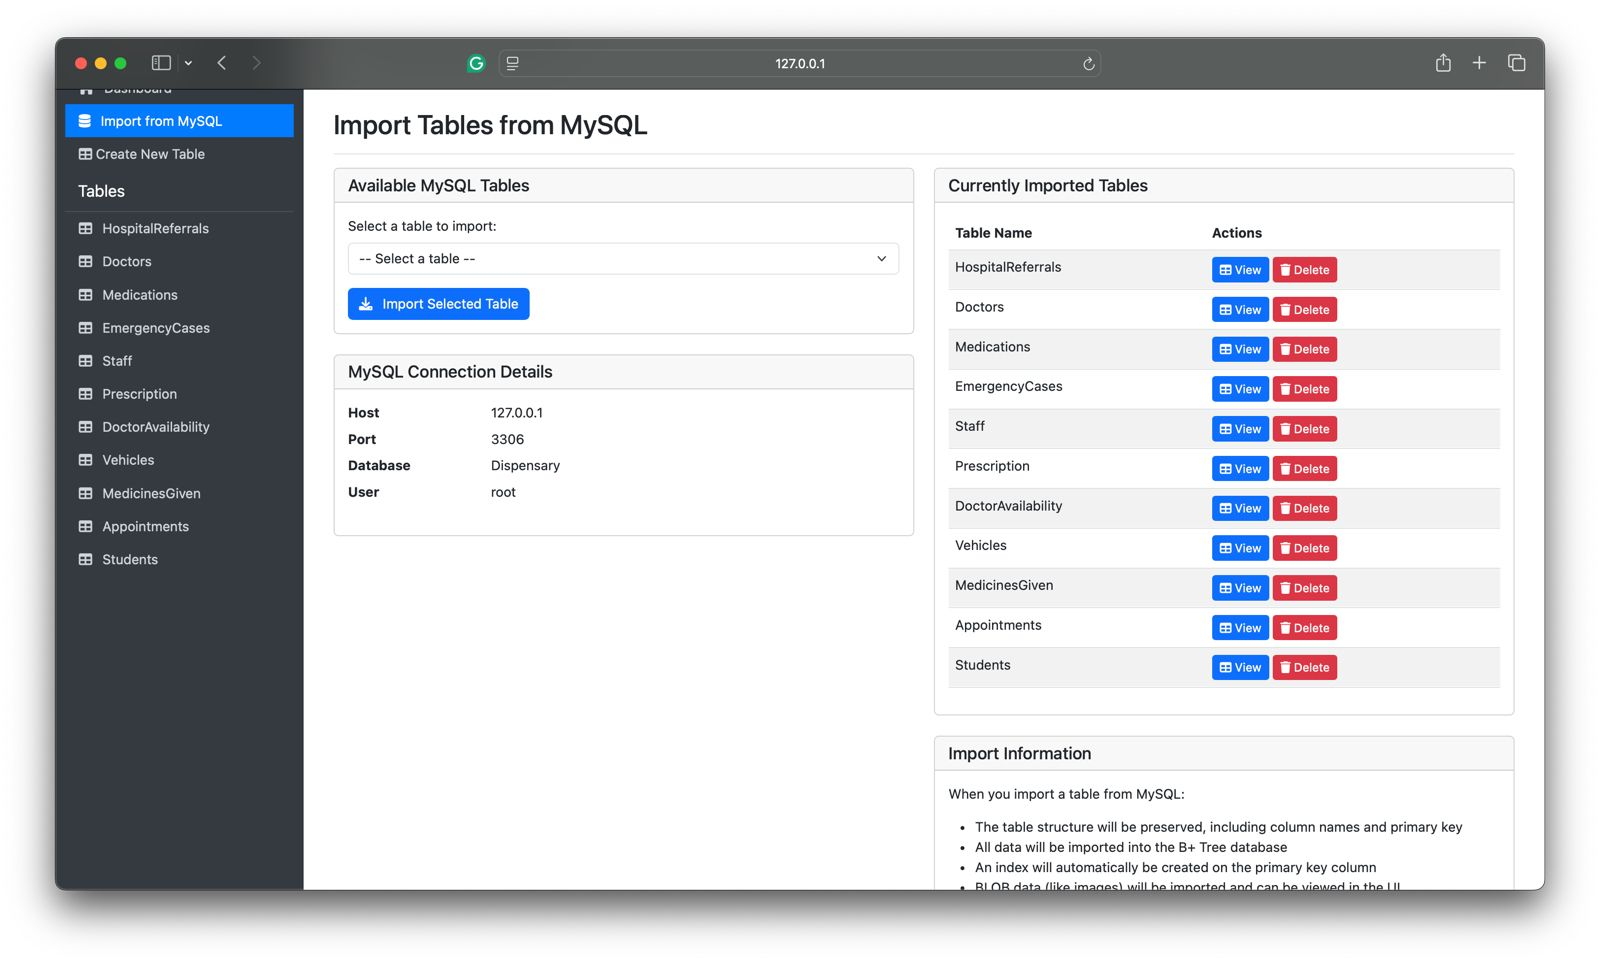

![WhatsApp Image 2025-04-23 at 16.26.49_59bd97fe.jpg](<attachment:WhatsApp Image 2025-04-23 at 16.26.49_59bd97fe.jpg>)
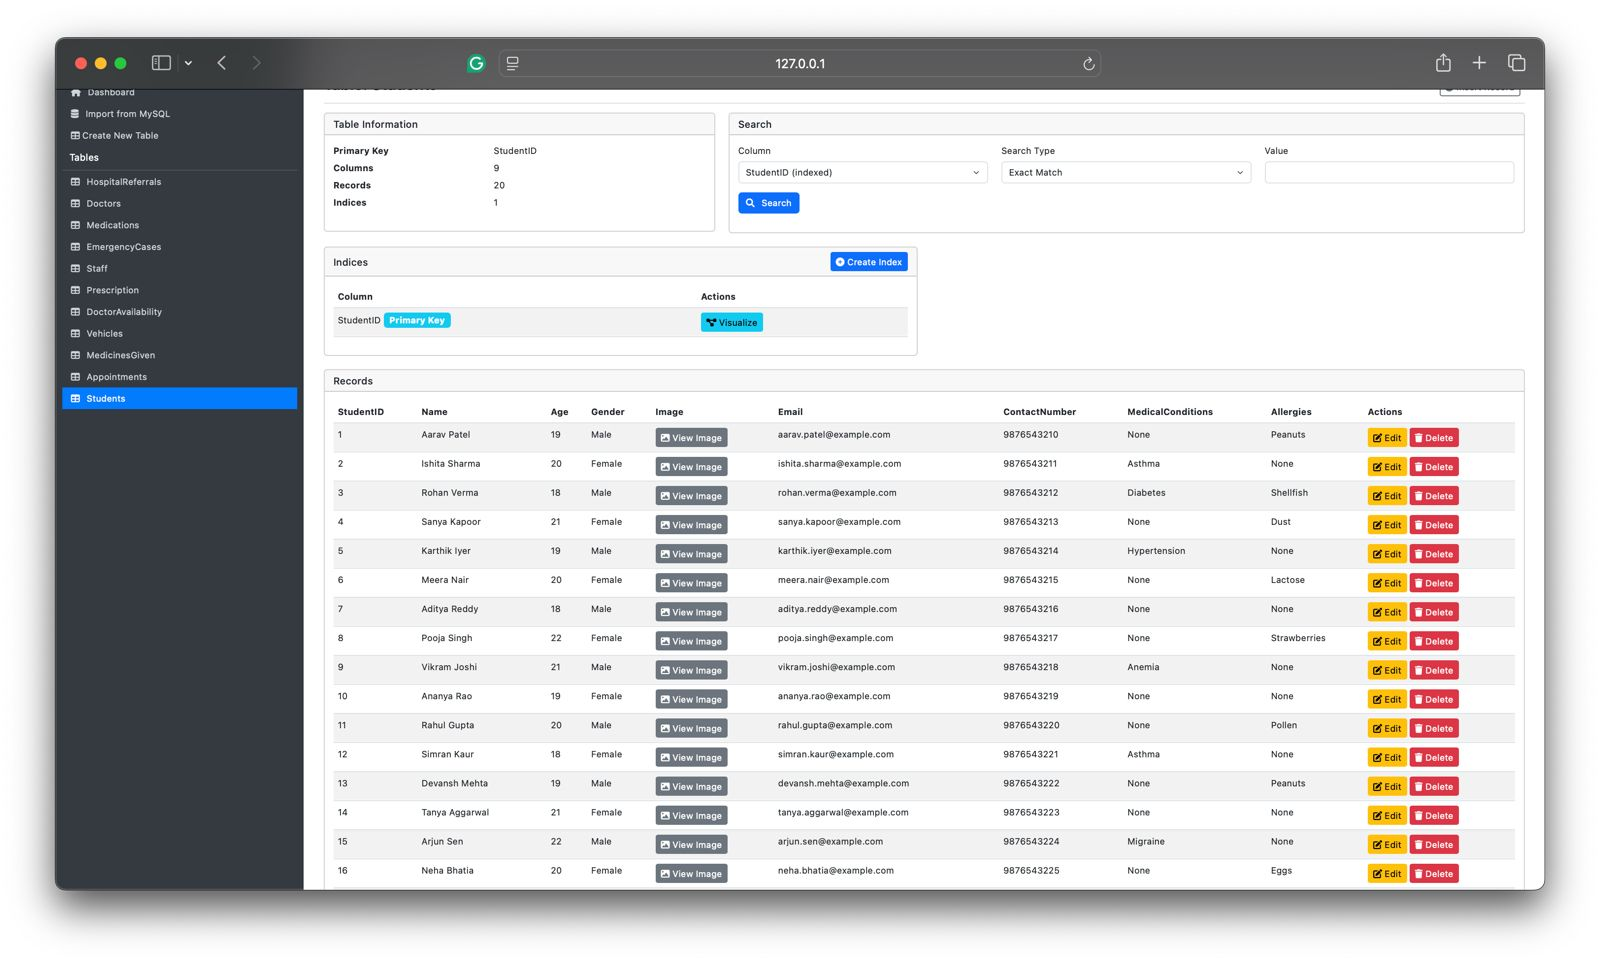

![WhatsApp Image 2025-04-23 at 16.28.39_153d91c6.jpg](<attachment:WhatsApp Image 2025-04-23 at 16.28.39_153d91c6.jpg>)
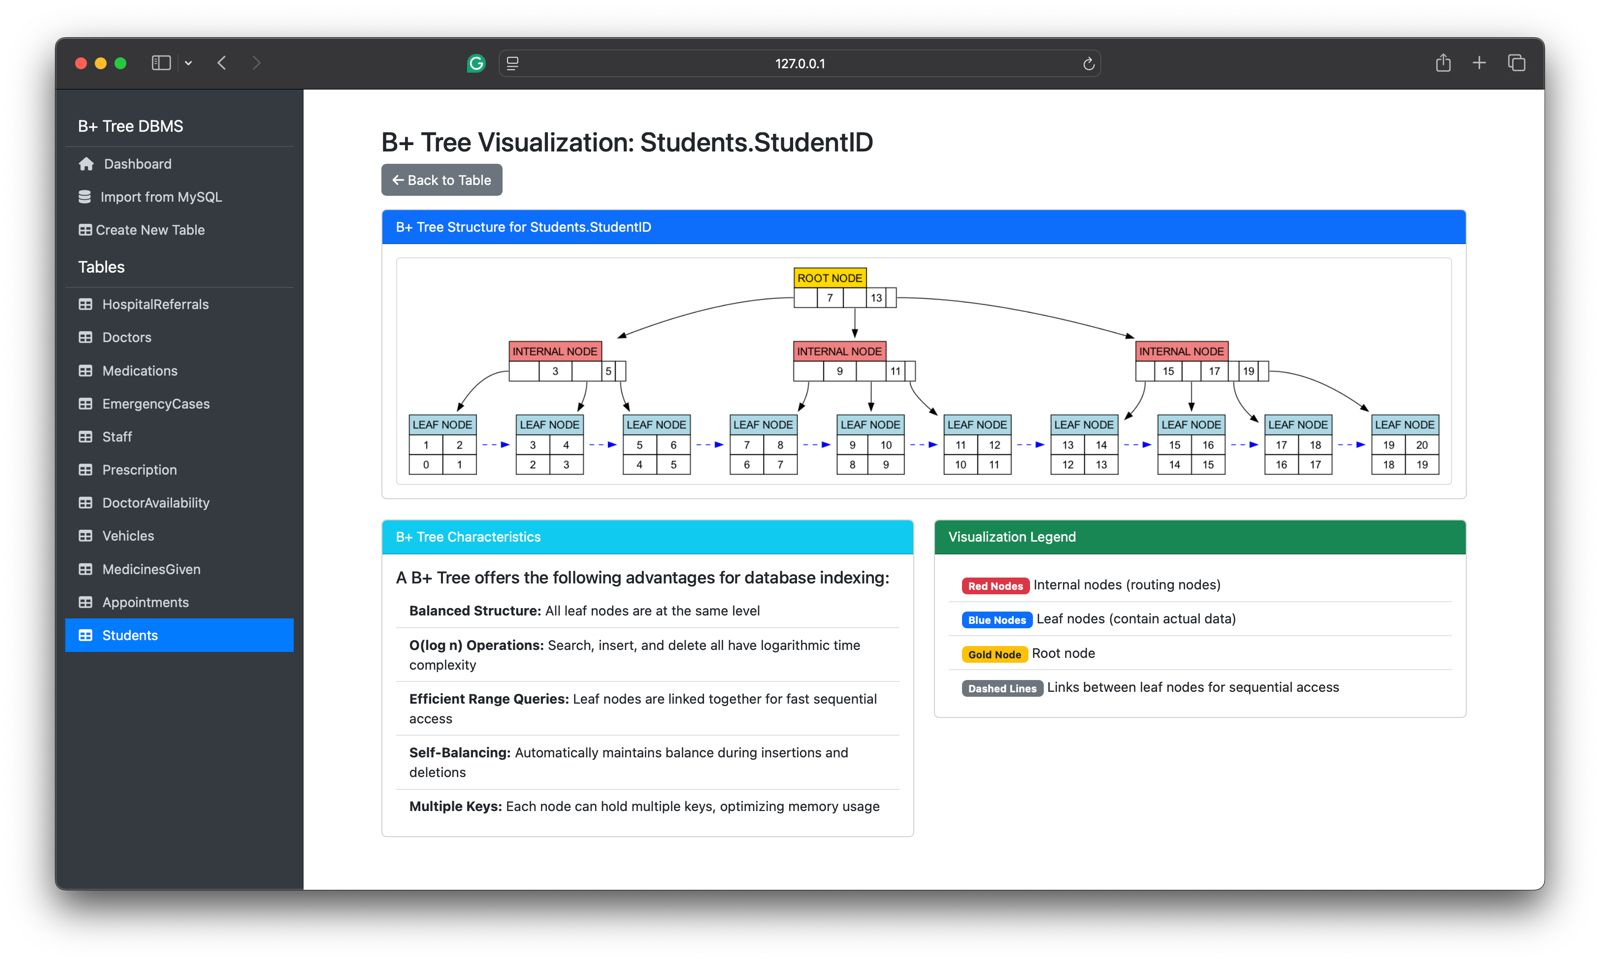

## 6. Conclusion

### 6.1 Summary of Findings

Our implementation of a B+ Tree-based Database Management System has demonstrated several key advantages:

1. **Efficient Querying**: The B+ Tree structure provides O(log n) time complexity for search operations, significantly outperforming brute force approaches, especially for larger datasets.

2. **Range Query Optimization**: The linked leaf node structure of B+ Trees enables very efficient range queries, a common operation in database systems.

3. **Scalability**: As our performance tests have shown, B+ Trees scale much better with increasing data size compared to brute force methods.

4. **Data Persistence**: The implementation successfully maintains database state between program executions, ensuring data durability.

5. **Multi-Index Support**: The ability to create multiple indices on different columns allows for efficient queries on various attributes.

### 6.2 Challenges Faced

During implementation, we encountered several challenges:

1. **Complex Tree Operations**: Maintaining tree balance during insertions and deletions required careful implementation of node splitting, merging, and redistributing.

2. **Persistence Implementation**: Serializing and deserializing B+ Trees while preserving their linked structure (particularly the leaf node links) was challenging.

3. **Performance Optimization**: Finding the optimal B+ Tree order and balancing memory usage with performance required empirical testing.

4. **Concurrency Issues**: While not fully addressed in this implementation, real-world database systems must handle concurrent operations on the B+ Tree.

### 6.3 Future Improvements

Several enhancements could further improve this database system:

1. **Transaction Support**: Adding ACID (Atomicity, Consistency, Isolation, Durability) transaction capabilities would make the system more robust for real-world applications.

2. **Concurrency Control**: Implementing mechanisms for safe concurrent access to the B+ Tree structures.

3. **Disk-Based B+ Tree**: Enhancing the implementation to better handle data that doesn't fit in memory by implementing paging and buffer management.

4. **Query Optimization**: Adding a query optimizer that can select the most efficient index for complex queries.

5. **SQL Interface**: Providing a SQL-like interface for more familiar database interaction.

6. **Advanced Indexing Techniques**: Implementing additional indexing structures like hash indices for exact match queries and R-trees for spatial data.

### 6.4 Final Thoughts

The B+ Tree data structure provides an excellent foundation for database indexing, offering a balance of efficient search, insertion, deletion, and range query operations. Our implementation demonstrates its practical applications in a simple but functional database management system with persistence capabilities.

The performance comparisons clearly show the advantages of using specialized data structures like B+ Trees over simpler approaches, particularly as data volume increases - a critical consideration for modern database systems.

## 7. References

1. Comer, D. (1979). The Ubiquitous B-Tree. ACM Computing Surveys, 11(2), 121-137.

2. Silberschatz, A., Korth, H. F., & Sudarshan, S. (2019). Database System Concepts (7th ed.). McGraw-Hill.

3. Ramakrishnan, R., & Gehrke, J. (2003). Database Management Systems (3rd ed.). McGraw-Hill.

4. Elmasri, R., & Navathe, S. B. (2016). Fundamentals of Database Systems (7th ed.). Pearson.